Processing pr_th = 0.5 mm/h


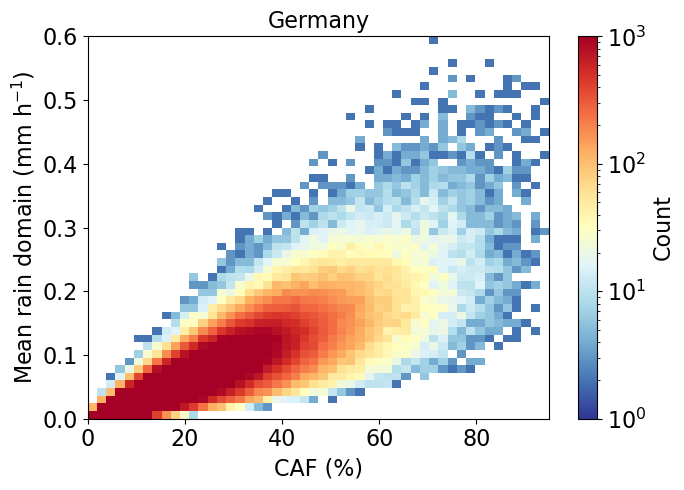

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d
import os

# ======= Set manually =======
country = "Germany"
region = "MC"
th_i = 0
xbins, ybins = 30, 60
xrange = [0, 15000]
yrange = [0, 60]
vmax = 60
min_count = 1
count_levels = [100, 1000, 10000]
# ============================

plot_folder = "/home/565/dl6968/hk25-AusNode-LargeScaleP/work_folder/Figures"
os.makedirs(plot_folder, exist_ok=True)

params = {     
    'axes.labelsize': '16',   
    'axes.titlesize': '16',  
    'xtick.labelsize': '16',
    'ytick.labelsize': '16',    
    'lines.linewidth': '2',   
    'legend.fontsize': '12', 
    'figure.figsize': '9, 7'    
}
plt.rcParams.update(params)

pr_th_list = [0.5, 1, 2, 3, 4, 5]
pr_th = pr_th_list[th_i]

print(f"Processing pr_th = {pr_th} mm/h")

output_path = f"/scratch/nf33/hk25_LSP/{country}/{region}_chunk/number_size_prth_{pr_th}_hourly.nc"
ds_ts = xr.open_dataset(output_path)

ds_cape = xr.open_dataset(f"/scratch/nf33/hk25_LSP/{country}/MC_chunk/cape_cin_2deg.nc").interp(time=ds_ts.time, method="linear")
# ds_cin = xr.open_dataset("/scratch/xp65/dl6968/prep_hk25/environment/radar_time/cin_steiner_ts.nc")
ds_w500 = xr.open_dataset(f"/scratch/nf33/hk25_LSP/{country}/MC_chunk/w500_2deg.nc").interp(time=ds_ts.time, method="linear")
ds_rh500 = xr.open_dataset(f"/scratch/nf33/hk25_LSP/{country}/MC_chunk/rh500_2deg.nc").interp(time=ds_ts.time, method="linear")

cape_ts = ds_cape["cape"].values
cin_ts = ds_cape["cin"].values
w500_ts = ds_w500["wa"].values
rh500_ts = ds_rh500["hur"].values

ds_ts = ds_ts.sel(time=ds_cape.time)

num_obj_arr = ds_ts["num_obj"].where(np.isfinite(ds_ts["num_obj"]), other=np.nan)
tot_area_arr = ds_ts["tot_area"].where(np.isfinite(ds_ts["tot_area"]), other=np.nan)
mean_obj_area_arr = ds_ts["mean_obj_area"].where(np.isfinite(ds_ts["mean_obj_area"]), other=np.nan)
area_frac_arr = ds_ts["area_frac"].where(np.isfinite(ds_ts["area_frac"]), other=np.nan) * 100
cvt_mean_prcp_arr = ds_ts["cvt_mean_prcp"].where(np.isfinite(ds_ts["cvt_mean_prcp"]), other=np.nan)
tot_mean_prcp_arr = ds_ts["tot_mean_prcp"].where(np.isfinite(ds_ts["tot_mean_prcp"]), other=np.nan)
cvt_tot_prcp_arr = ds_ts["cvt_tot_prcp"].where(np.isfinite(ds_ts["cvt_tot_prcp"]), other=np.nan)

# === First figure: 2D histogram ===
x = area_frac_arr.values.flatten()
y = tot_mean_prcp_arr.values.flatten()

counts, xedges, yedges = np.histogram2d(
    x, y,
    bins=50,
    range=[[0,95], [0,0.6]]#[np.nanmin(x), np.nanmax(x)], [np.nanmin(y), np.nanmax(y)]]
)

counts_masked = np.where(counts > min_count, counts, np.nan)
X, Y = np.meshgrid(xedges, yedges)

fig, ax = plt.subplots(figsize=(7, 5))
pcm = plt.pcolormesh(
    X, Y, counts_masked.T,
    norm=LogNorm(vmin=1, vmax=1000),
    cmap='RdYlBu_r',
    shading='auto'
)
plt.colorbar(pcm, label="Count")
plt.xlabel("CAF (%)")
plt.ylabel("Mean rain domain (mm h$^{-1}$)")
plt.xlim([0,95])
plt.ylim([0,0.6])
plt.title(f"Bins with sample size > {min_count}\n(pr_th = {pr_th} mm/h)")
fig.savefig(f"{plot_folder}/{country}_{region}_fig1-1_prth_{pr_th}mmh.png", dpi=300,bbox_inches="tight")
plt.title(country)

plt.tight_layout()
#plt.show()
# plt.close()

## === Second figure: Scatter plot ===
#plt.figure(figsize=(7, 5))
#plt.scatter(x, y, alpha=0.3, s=10)
#plt.xlabel("CAF (%)")
#plt.ylabel("Mean rain domain (mm h$^{-1}$)")
#plt.title(f"Scatter plot\n(pr_th = {pr_th} mm/h)")
#plt.tight_layout()
##plt.show()
#plt.close()




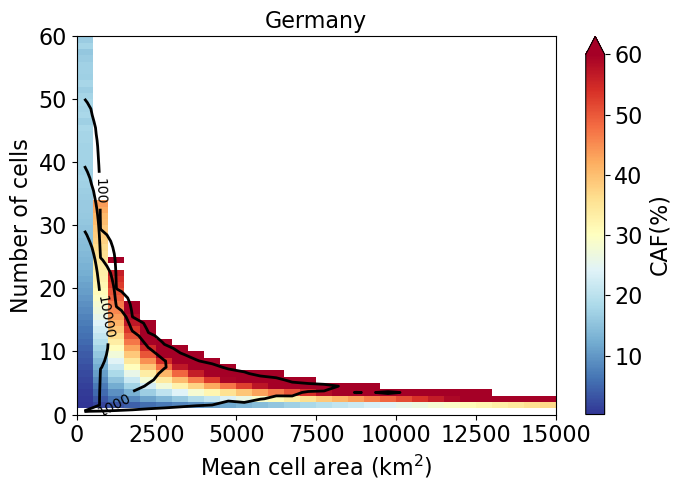

All plots done.


In [3]:
# === Third figure: 2D binned statistic plot ===
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = area_frac_arr.values.flatten()

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2, y2, z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

stat[counts <= 1] = np.nan
X, Y = np.meshgrid(xedges, yedges, indexing='xy')

x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

fig, ax = plt.subplots(figsize=(7, 5))
pcm = ax.pcolormesh(
    X, Y, stat.T,
    cmap='RdYlBu_r',
    shading='auto', vmax=vmax,
)
fig.colorbar(pcm, ax=ax, label="CAF(%)", extend="max")
cs = ax.contour(x_centers, y_centers, counts.T, levels=count_levels, colors="k")
ax.clabel(cs, inline=True, fontsize=10, fmt="%.0f")
ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel('Number of cells')
# ax.set_title(f"CAF (%) by Mean cell area and Number of cells\n(pr_th = {pr_th} mm/h)")
ax.set_title(f"{country}")

fig.savefig(f"{plot_folder}/{country}_{region}_caf_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

plt.show()
plt.close()

ds_ts.close()

print("All plots done.")

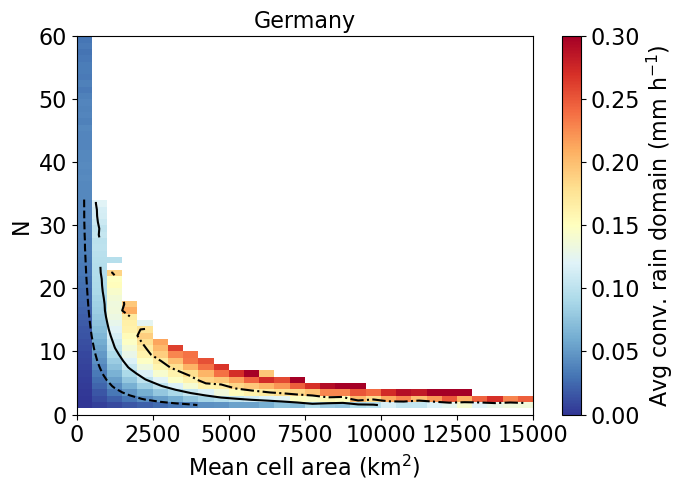

In [4]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = tot_mean_prcp_arr.values.flatten()


## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto', vmin=0, vmax=0.3
)
fig.colorbar(pcm, ax=ax, label="Avg conv. rain domain (mm h$^{-1}$)")

# 4) overlay contours at the three quartile levels
cs = ax.contour(
    Xc, Yc, stat.T,
    levels=[q25, q50, q75],
    colors='k',
    linestyles=['--','-','-.'],
    linewidths=1.5
)
# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
ax.set_title(f"{country}")

fig.savefig(f"{plot_folder}/{country}_{region}_acrd_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")
plt.tight_layout()


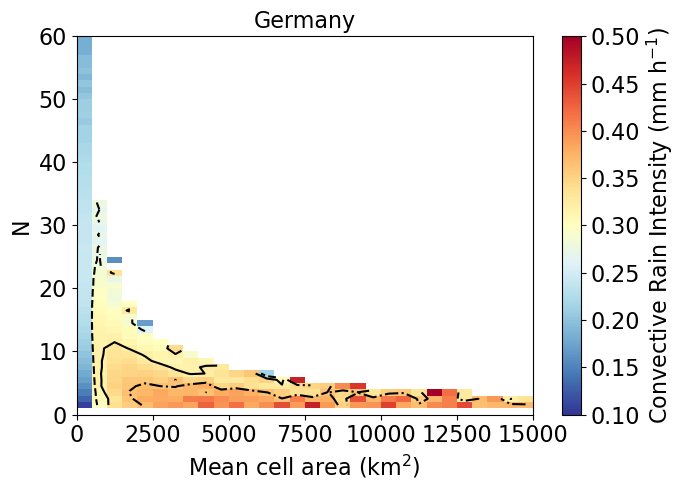

In [5]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = cvt_mean_prcp_arr.values.flatten()


## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan
## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto',vmin=0.1,vmax=0.5
)
fig.colorbar(pcm, ax=ax, label="Convective Rain Intensity (mm h$^{-1}$)")

# 4) overlay contours at the three quartile levels
cs = ax.contour(
    Xc, Yc, stat.T,
    levels=[q25, q50, q75],
    colors='k',
    linestyles=['--','-','-.'],
    linewidths=1.5
)
# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
ax.set_title(f"{country}")
fig.savefig(f"{plot_folder}/{country}_{region}_cri_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

## Environmental conditions

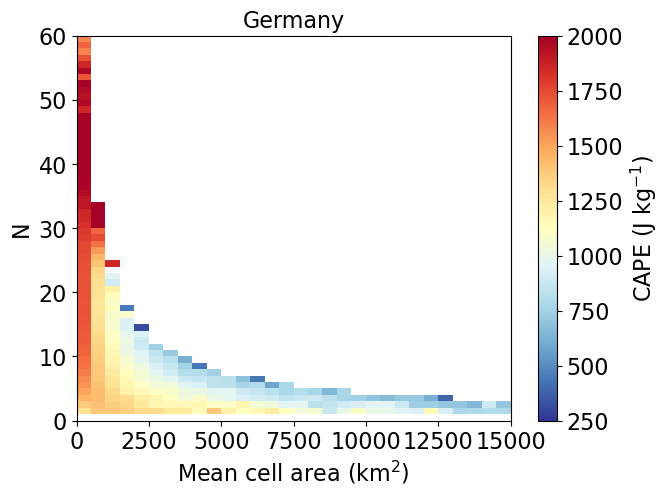

In [6]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = cape_ts.flatten()

# xbins, ybins = 50, 50
# xrange = [0,600]
# yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan
## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto',vmin=250,vmax=2000
)
fig.colorbar(pcm, ax=ax, label="CAPE (J kg$^{-1}$)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
# plt.tight_layout()
plt.title(f"{country}")
# plt.tight_layout()
fig.savefig(f"{plot_folder}/{country}_{region}_cape_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")


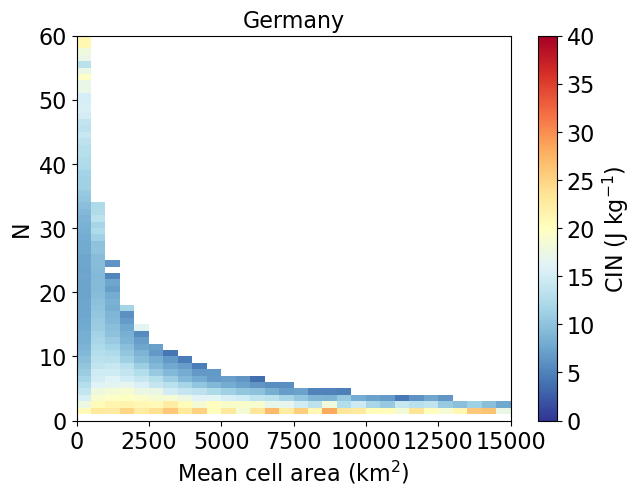

In [7]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = cin_ts.flatten()

# xbins, ybins = 50, 50
# xrange = [0,600]
# yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu_r', shading='auto',vmin=0,vmax=40
)
fig.colorbar(pcm, ax=ax, label="CIN (J kg$^{-1}$)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
# plt.tight_layout()
plt.title(f"{country}")
# plt.tight_layout()
fig.savefig(f"{plot_folder}/{country}_{region}_cin_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")


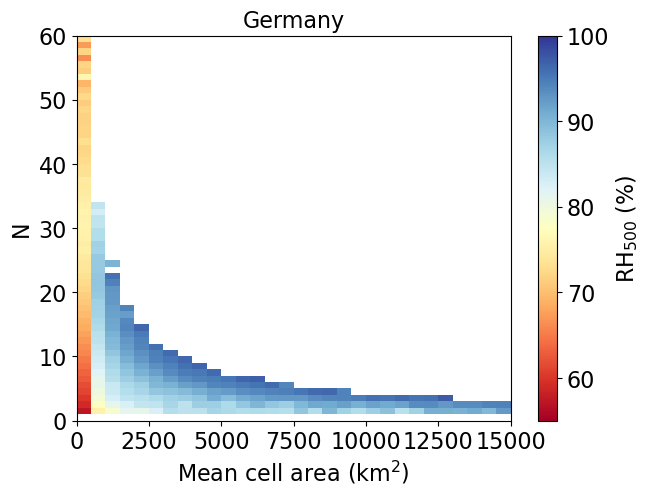

In [8]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = rh500_ts.flatten()

xbins, ybins = 30, 60
xrange = [0, 15000]
yrange = [0, 60]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu', shading='auto',vmin=55, vmax=100
)
fig.colorbar(pcm, ax=ax, label="RH$_{500}$ (%)")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
# plt.tight_layout()
plt.title(f"{country}")
# plt.tight_layout()
fig.savefig(f"{plot_folder}/{country}_{region}_rh500_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")


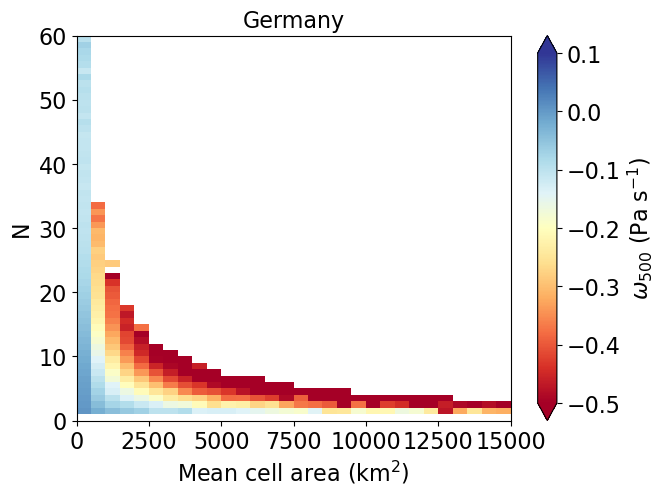

In [9]:
x = mean_obj_area_arr.values.flatten()
y = num_obj_arr.values.flatten()
z = w500_ts.flatten()

# xbins, ybins = 50, 50
# xrange = [0,600]
# yrange = [y.min(), y.max()]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan

## quartiles
vals = stat.flatten()
vals = vals[~np.isnan(vals)]
q25, q50, q75 = np.percentile(vals, [25, 50, 75])

# 2) make a centre–point grid for contour (rather than edges)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers)

# 3) pcolormesh your mean field
fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    xedges, yedges, stat.T,
    cmap='RdYlBu', shading='auto', vmin=-0.5, vmax=0.1
)
fig.colorbar(pcm, ax=ax, label="$\omega_{500}$ (Pa s$^{-1}$)",extend="both")

# ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel("N")
# plt.tight_layout()
plt.title(f"{country}")
# plt.tight_layout()
fig.savefig(f"{plot_folder}/{country}_{region}_w500_prth_{pr_th}mmh.png", dpi=300, bbox_inches="tight")
